In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image

import numba
import open3d as o3d

import cv2

from scipy.spatial import KDTree

from hough3d import genIcosahedron, courseGrainField, pathIntegralAlongField3D
from hough3d import reducedRepConversionMatrices, distancePointToLine, unravel_3d_index

from hough3d import animateGeometries

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Load Data

In [23]:
#testData = np.random.uniform(-1, 1, size=(10000, 3))

#dataPath = '/home/jack/Workspaces/data/point_clouds/local_regions/local_region_points_4.csv'
#dataPath = '/home/jack/Workspaces/python/skeletor/skeletor/data/simple_tree.npy'
dataPath = '/home/jack/Workspaces/data/point_clouds/2024-10-08_LG_A_PNG_MetroInv_1_contracted.npy'

with open(dataPath, 'rb') as f:
   data = np.load(f)

#data = np.genfromtxt(dataPath, delimiter=',')

data = data - np.mean(data, axis=0)
data = np.ascontiguousarray(data).astype(np.float64)[::1]
data.shape

(92256, 3)

In [31]:
dataPath = '/home/jack/Workspaces/data/point_clouds/test_line_data/synthetic_b.dat'

data = np.genfromtxt(dataPath, skip_header=6, delimiter=',')

data = data - np.mean(data, axis=0)
data = np.ascontiguousarray(data).astype(np.float64)
data.shape

(248, 3)

In [2]:
def rotationMatrix(theta, phi, psi):
    """
    Generate the rotation matrix corresponding to rotating
    a point in 3D space.
    """
    return np.array([[np.cos(theta)*np.cos(psi), np.cos(phi)*np.sin(psi) + np.sin(phi)*np.sin(theta)*np.cos(psi), np.sin(phi)*np.sin(psi) - np.cos(psi)*np.cos(phi)*np.sin(theta)],
                     [-np.cos(theta)*np.sin(psi), np.cos(phi)*np.cos(psi) + np.sin(phi)*np.sin(theta)*np.sin(psi), np.sin(phi)*np.cos(psi) - np.cos(psi)*np.sin(phi)*np.sin(theta)],
                     [np.sin(theta), -np.sin(phi)*np.cos(theta), np.cos(phi)*np.cos(theta)]])


rawData = np.genfromtxt('data.csv', delimiter=',')
nLines = 5

data = np.zeros((len(rawData)*nLines, 3))

for i in range(nLines):
    data[len(rawData)*i:len(rawData)*(i+1),:2] = rawData*2
    data[len(rawData)*i:len(rawData)*(i+1)] += np.random.uniform(-1, 1, size=3)
    
    angles = np.random.uniform(0, np.pi, size=2)
    
    mat = rotationMatrix(*angles, 0)
    data[len(rawData)*i:len(rawData)*(i+1)] = data[len(rawData)*i:len(rawData)*(i+1)] @ mat + np.random.uniform(-1, 1, size=data[len(rawData)*i:len(rawData)*(i+1)].shape)*1e-2

data.shape

(3980, 3)

## Basic Hough

In [32]:
from hough3d import hough3D

directionGranularity = 4
directionVectors = genIcosahedron(directionGranularity)

linePoints = hough3D(data, directionVectors, latticeSize=128, neighborDistance=0.05, minPointsPerLine=20)
linePoints.shape

(4, 2, 3)

In [33]:
flattenedLinePoints = linePoints.reshape((len(linePoints)*2, 3))

lineSet = o3d.geometry.LineSet()
lineSet.points = o3d.utility.Vector3dVector(flattenedLinePoints)
lineSet.lines = o3d.utility.Vector2iVector([[i,i+1] for i in range(len(flattenedLinePoints))[::2]])

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(data)

o3d.visualization.draw_geometries([lineSet, pcd])

In [34]:
outputName = ''.join(dataPath.split('/')[-1].split('.')[:-1]) + '.gif'
animateGeometries([lineSet, pcd], outputName, rotationSpeed=12, maxFrames=90, crop=True)
print(f'Saved as {outputName}')

Saved as synthetic_b.gif


## Integrated Hough

In [3]:
@numba.njit()
def lineIntersection(a1, b1, a2, b2):
    """
    Compute the intersection of two lines:
        a1 + b1*t and a2 + b2*t
    """
    # Compute the cross product
    crossProd = np.cross(b1, b2)
    if crossProd == 0:
        return np.nan
    # Dot the cross product unit vector into the vector from intercept to intercept
    distance = np.dot(a2 - a1, crossProd) / np.sqrt(np.sum(crossProd**2))
    return distance

@numba.njit()
def distancePointToLine(p, a, b):
    """
    Compute intersection of a point (p) with a line (a + bt).

    Parameters
    ----------
    p : numpy.ndarray[3]
        Point to compute distance to the line

    a : numpy.ndarray[3]
        Point located on the line.

    b : numpy.ndarray[3]
        Direction vector of the line.

    Returns
    -------
    d : float
        Distance from the point to the closest point
        on the line.
    """
    t = np.dot(b, p - a)
    closestPointOnLine = a + t*b
    return np.sqrt(np.sum((p - closestPointOnLine)**2))


@numba.njit()
def integratedHough3D(points, directionVectors, averageNNDistance, latticeSize=64, neighborDistance=0.01, lineJumpDistance=5, refinementSteps=2, minPointsPerLine=5):
    """
    Perform line detection on a 3D point cloud.

    This version of the function is follows the algorithm described in
    the original paper [1] (except for step 5):
        1. Have all points vote in the hough space.
        2. Take the highest voted cell as an initial guess for a new line.
        3. Find all points less than a certain distance to the initial line.
        4. Perform linear regression on the nearby points to refine the line.
        5. Update which points are nearby to the line based on the updated line (NEW).
        6. Have all of the points that are part of this line reverse their vote.
        7. Repeat steps 2-6 until there are not enough points left to form a line.

    I found that adding step 5 gave slightly more reliable detections, so
    I have included it. Note that you could take this further, and perform
    several steps of fitting and updating, but here we just do one.
    
    Parameters
    ----------
    points : numpy.ndarray[N,3]
        Points representing the point cloud.

    directionVectors : numpy.ndarray[M,3]
        Direction vectors represented the discretized directions for
        the lines. Normally generated with `genIcosahedron()`.

    densityField : numpy.ndarray[Q,P,R]
        Course grained density field for the point cloud

    densityFieldCorner : numpy.ndarray[3]
        The point representing the bottom left (minimum) corner of the
        density field, if not [0,0,0].
        
    latticeSize : int
        The number of discrete boxes to use for the intercept variables in
        hough space.

    neighborDistance : float
        The distance a point can be from the initial guess of a
        line for it to be included in the linear regression
        used to refine the line parameters. Given as fraction of
        the total system size (diagonal length of the bounding box).

    minPointsPerLine : int
        The minimum number of points that must be part of a line
        detection for that line to be included in the final result.

    Returns
    -------
    lineDirections : numpy.ndarray[K,3]
        The vectors giving the directions of detected lines.

    lineAnchorPoints : numpy.ndarray[K,3]
        The position vectors of the anchor point for each line,
        roughly representing the center of the line (but not
        exactly).

    lineLengths : numpy.ndarray[K]
        The length of each line.
    """
    ##############################################
    #              Preparation steps
    ##############################################
    # Shift the mean of the point cloud to the origin
    pointCloudTranslation = np.zeros(3)
    for i in range(3):
        pointCloudTranslation[i] = np.mean(points[:,i])
        
    points = np.copy(points) - pointCloudTranslation
    
    # Compute the discrete direction vectors for our lines
    #directionVectors = genIcosahedron(directionGranularity)
    # TODO: Make this generation function numba compatable
    
    # Find the extents of the point cloud
    bounds = np.zeros((2, 3))
    for i in range(3):
        bounds[:,i] = [np.min(points[:,i]), np.max(points[:,i])]
    #bounds = np.array([ for i in range(3)]).T

    systemLengthScale = np.sqrt(np.sum((bounds[1] - bounds[0])**2))

    stepSize = systemLengthScale / latticeSize

    # Our hough space will be a three dimensional array, with the first two
    # dimensions representing the reduced coordinates x' and y' for the
    # intersection point of a line with a plane that passes through [0,0,0],
    # and the last dimension for the direction vector of the line. Altogether,
    # a point i,j,k in the hough space fully describes a line in the space
    # of the point cloud.
    houghSpaceSize = (latticeSize, latticeSize, len(directionVectors))

    ##############################################
    #    Initial transformation to hough space
    ##############################################
    # The actual hough space where points will be voting
    houghSpace = np.zeros(houghSpaceSize)

    # Now do the voting
    for k in range(len(directionVectors)):
        b = directionVectors[k]
        # We can compute a vector in advance that we just dot with
        # each point to find the x' and y'
        # See equation 2 in Dalitz et al. 2017
        reducedRepMultX, reducedRepMultY = reducedRepConversionMatrices(b)

        # I'm not 100% clear on why adding the system length scale is
        # necessary here, but otherwise most of our lattice represents
        # values of x' and y' that aren't relevant...
        xPrime = np.dot(reducedRepMultX, points.T) + systemLengthScale/2
        yPrime = np.dot(reducedRepMultY, points.T) + systemLengthScale/2
        #xPrime = np.dot(reducedRepMultX, points.T) + systemLengthScale/2
        #yPrime = np.dot(reducedRepMultY, points.T) + systemLengthScale/2

        # Now convert to an index, so we can find the corresponding
        # place on the hough space lattice.
        xIndex = np.floor(xPrime / stepSize).astype(np.uint8)
        yIndex = np.floor(yPrime / stepSize).astype(np.uint8)

        # Get rid of indices that are not on our lattice
        validIndices = np.where((xIndex < latticeSize) & (yIndex < latticeSize))[0]

        #print(validIndices)
        for j in validIndices:
            houghSpace[xIndex[j], yIndex[j], k] += 1
    
    ##############################################
    #    Iterative selection of lines
    ##############################################
    # Now that we have calulated our hough space, we need to identify
    # maxima in it to find the best lines

    # We do this by starting with the most voted point in hough space
    # and then "unvote" all of the points that are associated with that
    # line, and then repeat the process iteratively
    
    # # Naively, we just start by taking the maximum cells
    # maxIndices = np.where(houghSpace >= np.max(houghSpace)*selectionThreshold)
    # # Convert to a nicer format, so we can directly index using
    # # maxIndices[i]
    # maxIndices = [(maxIndices[0][i], maxIndices[1][i], maxIndices[2][i]) for i in range(len(maxIndices[0]))]

    # Numba doesn't play well with empty arrays because
    # it can't infer the type of the data, so we just start
    # with an empty line (all zeros) and we will remove
    # it at the end (see return statement).
    # First index is for line, second is for start/end point,
    # and third is for dimension in 3D space
    linePointArr = np.zeros((1, 2, 3))

    while True:
        # The highest voted space
        maxIndex = np.argmax(houghSpace)
        # Now we have to unravel the index, since it is given as a 1D index
        # The function numpy.unravel_index() does this, but it is not supported
        # by numba
        xIndex, yIndex, bIndex = unravel_3d_index(maxIndex, houghSpaceSize)

        # If we don't have enough points, we finish
        # This probably shouldn't be here, because we could
        # have many points in a line that just didn't vote for the
        # specific lattice spot because of discretization artifacts
        if houghSpace[xIndex,yIndex,bIndex] < minPointsPerLine/2:
            print('Exit because not enough votes in highest voted cell')
            break
            
        #print(maxIndex)
        print(f'Number of votes: {int(houghSpace[xIndex,yIndex,bIndex])}')

        # plt.imshow(houghSpace[:,:,bIndex])
        # plt.colorbar()
        # plt.title(f'b = {bIndex}')
        # plt.show()
        
        # Converted from index to reduced coordinates
        xPrime = xIndex*stepSize - systemLengthScale/2
        yPrime = yIndex*stepSize - systemLengthScale/2

        # Calculate the anchor point on the line, which,
        # together with the direction vector, fully identifies
        # the line.
        initialDirectionVector = directionVectors[bIndex]
        reducedRepMultX, reducedRepMultY = reducedRepConversionMatrices(initialDirectionVector)
        # See equation 3 from Dalitz et al. 2017
        anchorPoint = xPrime*reducedRepMultX + yPrime*reducedRepMultY

        # Now, we need to refine the line using linear regression.
        # First, that means identifying which points are included in
        # this line.
        
        # First, identify points that are within a certain distance of the entire
        # line
        distancesToPoints = np.array([distancePointToLine(p, anchorPoint, initialDirectionVector) for p in points])
        nearbyPointIndices = np.where(distancesToPoints < averageNNDistance*neighborDistance)[0]
        nearbyPoints = points[nearbyPointIndices]

        print(f'Number of nearby points: {len(nearbyPoints)}')

        if len(nearbyPoints) < minPointsPerLine:
            print('Exit because not enough nearby points detected')
            break

        # Now, we want to see how points are distributed throughout the
        # space along the line. This lets us distinguish, for example,
        # two distinct line segments that have the same slope and intercept, but
        # are separated by some distance.
        # Parametrize the points along the line
        tArr = np.dot(initialDirectionVector, (nearbyPoints - anchorPoint).T)

        # Weight by the distance from the line
        tArr = tArr# * distancesToPoints[nearbyPointIndices]

        # Convert to a density map along the line
        pathPoints = 50
        pointDensityAlongLine, binEdges = np.histogram(tArr, pathPoints)

        # Can do this because the direction vector is a unit vector
        pathStepSize = (np.max(tArr) - np.min(tArr))/pathPoints
        
        # Next we need a threshold by which to binarize this point density
        # to indicate whether we are currently next to a line segment or not
        # We can use the average density of points in the volume to predict
        # the number of points we expect on average in a volume of 1/pathPoints**3.
        averageNumberOfPoints = len(points) / pathPoints**3
        
        # plt.plot(pointDensityAlongLine)
        # plt.axhline(averageNumberOfPoints)
        # plt.show()
        
        ##############################################
        #    DEBUG
        ##############################################
        # Uncomment these to plot each line after it is detected.
        # Doesn't work with numba, so you'll have to remove the annotation.

        # flattenedLinePoints = [anchorPoint - 10*initialDirectionVector, anchorPoint + 10*initialDirectionVector]
        
        # lineSet = o3d.geometry.LineSet()
        # lineSet.points = o3d.utility.Vector3dVector(flattenedLinePoints)
        # lineSet.lines = o3d.utility.Vector2iVector([[i,i+1] for i in range(len(flattenedLinePoints))[::2]])
        
        # pcd = o3d.geometry.PointCloud()
        # pcd.points = o3d.utility.Vector3dVector(points)
        # pcd.paint_uniform_color([0, 1, 0])

        # pcd2 = o3d.geometry.PointCloud()
        # pcd2.points = o3d.utility.Vector3dVector(nearbyPoints)
        # pcd2.paint_uniform_color([1, 0, 0])

        # o3d.visualization.draw_geometries([lineSet, pcd, pcd2])
        ##############################################
        #    DEBUG
        ##############################################        
            
        ##############################################
        #    Compute line cut of density field
        ##############################################
        # Unlike the basic algorithm, here we try to better distinguish
        # if there are multiple, distinct line segments along this line.
        # eg. consider two line segments that are aligned with each other
        # but on opposite sides of the point cloud; these shouldn't be
        # detected as a single line, since the segment in the middle
        # isn't actually a real line segment.

        pointDensityAlongLine[pointDensityAlongLine >= averageNumberOfPoints] = 1
        pointDensityAlongLine[pointDensityAlongLine < 1] = 0
        
        # Next, we fill in gaps under the allowed distance
        allowedSkipDistance = averageNNDistance*neighborDistance*lineJumpDistance
        allowedSkipDistance /= pathStepSize
        #print(allowedSkipDistance)

        for i in range(len(pointDensityAlongLine)):
            leftAllowedPoints = [i-k for k in range(int(np.floor(allowedSkipDistance))) if i-k >= 0]
            rightAllowedPoints = [i+k for k in range(int(np.floor(allowedSkipDistance))) if i+k < len(pointDensityAlongLine)]

            # If there is a high density point on both sides of the current point,
            # then we can fill in this current point.
            leftBounded = True in [pointDensityAlongLine[lI] == 1 for lI in leftAllowedPoints]
            rightBounded = True in [pointDensityAlongLine[rI] == 1 for rI in rightAllowedPoints]
            if leftBounded and rightBounded:
                pointDensityAlongLine[i] = 1

        # Now we split the line into regions that
        # are above the density threshold, since there could
        # be multiple lines that otherwise would get detected
        # as a single one.
        lineSegmentRegions = []
        inRegion = False
        for i in range(len(pointDensityAlongLine)):
            if pointDensityAlongLine[i] == 1 and not inRegion:
                lineSegmentRegions.append([i, 0])
                inRegion = True

            if pointDensityAlongLine[i] == 0 and inRegion:
                lineSegmentRegions[-1][1] = i-1
                inRegion = False

        # If our region extends to the end, we have to close it
        if inRegion:
            lineSegmentRegions[-1][1] = len(pointDensityAlongLine)-1

        
        # plt.plot(pointDensityAlongLine)
        # plt.show()

        # If we have no regions, we can't continue
        if len(lineSegmentRegions) == 0:
            print('Exit because no line segments were detected')
            break
            
        # fig = plt.figure()
        # ax = fig.add_subplot(projection='3d')
        
        # for j in range(len(lineSegmentRegions)):
        #     # Find which points are relevant to this line segment
        #     # Middle of line segment based on the line cut
        #     middleSegmentIndex = (lineSegmentRegions[j][0] + lineSegmentRegions[j][1]) / 2
        #     lineSegmentCenter = (anchorPoint + np.min(tArr)*initialDirectionVector) + middleSegmentIndex*pathStepSize*initialDirectionVector
        #     # Add a bit of padding to the radius
        #     lineSegmentHalfLength = (lineSegmentRegions[j][1] - lineSegmentRegions[j][0])*pathStepSize*1.1/2
        #     # Looking in a circle is fine because we have already restricted our points to
        #     # be on a line

        #     sphericalDistanceToPoints = np.sqrt(np.sum((lineSegmentCenter - nearbyPoints)**2, axis=-1))
        #     lineSegmentPointIndices = np.where(sphericalDistanceToPoints < lineSegmentHalfLength)[0]
        #     #lineSegmentPointIndices = np.arange(len(nearbyPoints))
        #     lineSegmentPoints = nearbyPoints[lineSegmentPointIndices]
        #     ax.scatter(*lineSegmentPoints.T, alpha=0.1)
        #     ax.scatter(*lineSegmentCenter[None].T)
        #     print(j, len(lineSegmentPoints))
            
        # plt.show()
        
        # Now, we need to break these points up into the segments we identified through
        # the density analysis.
        # DEBUG:
        #lineSegmentRegions = [[0, pathPoints-1]]
        #print(lineSegmentRegions)
        for j in range(len(lineSegmentRegions)):
            
            # plt.plot(pointDensityAlongLine)
            # plt.axvline(lineSegmentRegions[j][0], c='r')
            # plt.axvline(lineSegmentRegions[j][1], c='r')
            # plt.title(j)
            # plt.show()

            # Find which points are relevant to this line segment
            # Middle of line segment based on the line cut
            middleSegmentIndex = (lineSegmentRegions[j][0] + lineSegmentRegions[j][1]) / 2
            lineSegmentCenter = (anchorPoint + np.min(tArr)*initialDirectionVector) + middleSegmentIndex*pathStepSize*initialDirectionVector
            # Add a bit of padding to the radius
            lineSegmentHalfLength = (lineSegmentRegions[j][1] - lineSegmentRegions[j][0])*pathStepSize*1.1/2

            #print(f'Line segment center: {lineSegmentCenter}')
            #print(f'Line segment half width: {lineSegmentHalfWidth}')
            
            # Looking in a circle is fine because we have already restricted our points to
            # be on a line
            sphericalDistanceToPoints = np.sqrt(np.sum((lineSegmentCenter - nearbyPoints)**2, axis=-1))
            # plt.hist(sphericalDistanceToPoints, bins=30)
            # plt.show()
            
            lineSegmentPointIndices = np.where(sphericalDistanceToPoints < lineSegmentHalfLength)[0]
            #lineSegmentPointIndices = np.arange(len(nearbyPoints))
            lineSegmentPoints = nearbyPoints[lineSegmentPointIndices]
            #print(f'Number of points in line segment {j}: {len(lineSegmentPoints)}')
            
            # fig = plt.figure()
            # ax = fig.add_subplot(projection='3d')

            # ax.scatter(*nearbyPoints.T, alpha=0.5)
            # ax.scatter(*lineSegmentPoints.T, alpha=0.5)
            # ax.plot(*np.array([anchorPoint - b*5, anchorPoint + b*5]).T, '--', c='r')

            # plt.show()
            # Remove the used points from the list
            # Indexing is slightly complicated because we did it in two steps
            # points -> nearbyPoints -> lineSegmentPoints
            # So we have to go backwards one step at a time
            # That is; `nearbyPointIndices` gives the indices of points in
            # `points` that are included in `nearbyPoints`, and `lineSegmentPointIndices`
            # gives the indices of points in `nearbyPoints` that are included
            # in `lineSegmentPoints`
            
            # keepIndices = np.array([i for i in range(len(points)) if i not in nearbyPointIndices[lineSegmentPointIndices]], dtype=np.int64)
            # #print(f'removed {len(points) - len(keepIndices)} points')
            # points = points[keepIndices]

            ##############################################
            #    Refining line parameters
            ##############################################
            # If we have enough points, we continue on to calculate the
            # properties of the line
            # Otherwise, we just unvote these points and move on.
            if len(lineSegmentPoints) >= minPointsPerLine:
    
                # Now we perform linear regression on those points to fit a line
                # and increase the accuracy of our detected line
        
                # We will use SVD to find the first principle component
                # of the local points, which is equivalent to a linear
                # fit.
                # To do this, we need our data to be zero-centered
                # (and we need the center of mass point anyway as our
                # anchor point)
                anchorPoint = np.zeros(3)
                for i in range(3):
                    anchorPoint[i] = np.mean(lineSegmentPoints[:,i])
    
                # SVD on the mean-centered data.
                # The original paper did PCA instead of SVD, as they said it
                # was much faster, but I think SVD is fine here...
                uu, dd, vv = np.linalg.svd(lineSegmentPoints - anchorPoint)
                # Direction vector is the first principle component
                directionVector = vv[0]
                    
                # Compute the length of the line
                # The best way to do this is to compute the parametric representation
                # of every point in lineSegmentPoints. Then we can take the maximum and
                # minimum parametric values, to find how far the line extends in each direction
                tArr = np.dot(directionVector, (lineSegmentPoints - anchorPoint).T)
                lineStart = anchorPoint + np.max(tArr)*directionVector
                lineEnd = anchorPoint + np.min(tArr)*directionVector

                linePoints = np.zeros((2, 3))
                linePoints[0] = lineStart
                linePoints[1] = lineEnd
                
                # Save the information about this line
                linePointArr = np.concatenate((linePointArr, linePoints[None,:,:]))
                #print(f'Saved information about line segment {j}')

            
            keepIndices = np.array([i for i in range(len(points)) if i not in nearbyPointIndices[lineSegmentPointIndices]], dtype=np.int64)
            #print(f'removed {len(points) - len(keepIndices)} points')
            points = points[keepIndices]
                      
        ##############################################
        #    Removing votes from used points
        ##############################################
        # Now, we want to have all of the points
        # involved in this fit to "unvote" in the hough space,
        # such that we can find the next best line            
        for k in range(len(directionVectors)):
            b = directionVectors[k]
            # We can compute a vector in advance that we just dot with
            # each point to find the x' and y'
            # See equation 2 in Dalitz et al. 2017
            reducedRepMultX, reducedRepMultY = reducedRepConversionMatrices(b)
    
            # I'm not 100% clear on why adding the system length scale is
            # necessary here, but otherwise most of our lattice represents
            # values of x' and y' that aren't relevant...
            xPrime = np.dot(reducedRepMultX, nearbyPoints.T) + systemLengthScale/2
            yPrime = np.dot(reducedRepMultY, nearbyPoints.T) + systemLengthScale/2
            #xPrime = np.dot(reducedRepMultX, points.T) + systemLengthScale/2
            #yPrime = np.dot(reducedRepMultY, points.T) + systemLengthScale/2
    
            # Now convert to an index, so we can find the corresponding
            # place on the hough space lattice.
            xIndex = np.floor(xPrime / stepSize).astype(np.int32)
            yIndex = np.floor(yPrime / stepSize).astype(np.int32)
    
            # Only take the indices that are on the lattice
            validIndices = np.where((xIndex < latticeSize) & (yIndex < latticeSize))[0]

            #houghSpace[xIndex[validIndices],yIndex[validIndices], np.repeat(k,len(validIndices)).astype(np.int32)] -= 1
            for j in validIndices:
                houghSpace[xIndex[j], yIndex[j], k] -= 1

            #print(np.unique(np.where(houghSpace - oldHough < 0)[-1], return_counts=True))
            
            ##############################################
            #    DEBUG
            ##############################################
            # Uncomment these to plot each line after it is detected.
            # Doesn't work with numba, so you'll have to remove the annotation.

            # if len(lineSegmentPoints) > minPointsPerLine:
            #     flattenedLinePoints = linePointArr.reshape((len(linePointArr)*2, 3))
                
            #     lineSet = o3d.geometry.LineSet()
            #     lineSet.points = o3d.utility.Vector3dVector(flattenedLinePoints)
            #     lineSet.lines = o3d.utility.Vector2iVector([[i,i+1] for i in range(len(flattenedLinePoints))[::2]])
                
            #     pcd = o3d.geometry.PointCloud()
            #     pcd.points = o3d.utility.Vector3dVector(lineSegmentPoints)
                
            #     pcd2 = o3d.geometry.PointCloud()
            #     pcd2.points = o3d.utility.Vector3dVector(points)
            #     pcd2.paint_uniform_color([0.4, 0.4, 0.4])
                
            #     o3d.visualization.draw_geometries([lineSet, pcd2, pcd])
            ##############################################
            #    DEBUG
            ##############################################        
    

    # Remove the first entry, since that was a dummy entry
    return linePointArr[1:] + pointCloudTranslation

In [16]:
@numba.njit(cache=True)
def lineSegmentHough3D(points, directionVectors, latticeSize=128, neighborDistance=0.01, minPointsPerLine=5, lineJumpDistance=1, requiredPointDensity=1):
    """
    Perform line detection on a 3D point cloud.

    This version of the function is follows the algorithm described in
    the original paper [1] (except for step 5):
        1. Have all points vote in the hough space.
        2. Take the highest voted cell as an initial guess for a new line.
        3. Find all points less than a certain distance to the initial line.
        4. Perform linear regression on the nearby points to refine the line.
        5. Update which points are nearby to the line based on the updated line (NEW).
        6. Have all of the points that are part of this line reverse their vote.
        7. Save the information about the detected line.
        8. Repeat steps 2-7 until there are not enough points left to form a line.

    I found that adding step 5 gave slightly more reliable detections, so
    I have included it. Note that you could take this further, and perform
    several steps of fitting and updating, but here we just do one.
    
    Parameters
    ----------
    points : numpy.ndarray[N,3]
        Points representing the point cloud.

    directionVectors : numpy.ndarray[M,3]
        Direction vectors represented the discretized directions for
        the lines. Normally generated with `genIcosahedron()`.

    latticeSize : int
        The number of discrete boxes to use for the intercept variables in
        hough space.

    neighborDistance : float
        The distance a point can be from the initial guess of a
        line for it to be included in the linear regression
        used to refine the line parameters. Given as fraction of
        the total system size (diagonal length of the bounding box).

    minPointsPerLine : int
        The minimum number of points that must be part of a line
        detection for that line to be included in the final result.

    Returns
    -------
    linePointArr : numpy.ndarray[K,2,3]
        The position vectors for the start and end of each
        line.

    """
    ##############################################
    #              Preparation steps
    ##############################################
    # Shift the mean of the point cloud to the origin
    pointCloudTranslation = np.zeros(3)
    for i in range(3):
        pointCloudTranslation[i] = np.mean(points[:,i])
        
    points = np.copy(points) - pointCloudTranslation
    
    # Compute the discrete direction vectors for our lines
    #directionVectors = genIcosahedron(directionGranularity)
    # TODO: Make this generation function numba compatable
    
    # Find the extents of the point cloud
    bounds = np.zeros((2, 3))
    for i in range(3):
        bounds[:,i] = [np.min(points[:,i]), np.max(points[:,i])]
    #bounds = np.array([ for i in range(3)]).T

    systemLengthScale = np.sqrt(np.sum((bounds[1] - bounds[0])**2))

    stepSize = systemLengthScale / latticeSize

    # Our hough space will be a three dimensional array, with the first two
    # dimensions representing the reduced coordinates x' and y' for the
    # intersection point of a line with a plane that passes through [0,0,0],
    # and the last dimension for the direction vector of the line. Altogether,
    # a point i,j,k in the hough space fully describes a line in the space
    # of the point cloud.
    houghSpaceSize = (latticeSize, latticeSize, len(directionVectors))

    ##############################################
    #    Initial transformation to hough space
    ##############################################
    # The actual hough space where points will be voting
    houghSpace = np.zeros(houghSpaceSize)

    # Now do the voting
    for k in range(len(directionVectors)):
        b = directionVectors[k]
        # We can compute a vector in advance that we just dot with
        # each point to find the x' and y'
        # See equation 2 in Dalitz et al. 2017
        reducedRepMultX, reducedRepMultY = reducedRepConversionMatrices(b)

        # I'm not 100% clear on why adding the system length scale is
        # necessary here, but otherwise most of our lattice represents
        # values of x' and y' that aren't relevant...
        xPrime = np.dot(reducedRepMultX, points.T) + systemLengthScale/2
        yPrime = np.dot(reducedRepMultY, points.T) + systemLengthScale/2

        # Now convert to an index, so we can find the corresponding
        # place on the hough space lattice.
        xIndex = np.floor(xPrime / stepSize).astype(np.int32)
        yIndex = np.floor(yPrime / stepSize).astype(np.int32)

        # Get rid of indices that are not on our lattice
        validIndices = np.where((xIndex < latticeSize) & (yIndex < latticeSize))[0]

        #print(validIndices)
        for j in validIndices:
            houghSpace[xIndex[j], yIndex[j], k] += 1

    ##############################################
    #    Iterative selection of lines
    ##############################################
    # Now that we have calulated our hough space, we need to identify
    # maxima in it to find the best lines

    # We do this by starting with the most voted point in hough space
    # and then "unvote" all of the points that are associated with that
    # line, and then repeat the process iteratively
    
    # Numba doesn't play well with empty arrays because
    # it can't infer the type of the data, so we just start
    # with an empty line (all zeros) and we will remove
    # it at the end (see return statement).
    # First dimension indexes the line, second the start or end point
    # of the line, and the final dimension is for the space we are in.
    linePointArr = np.zeros((1, 2, 3))
    maxIndex = -1
    
    while True:
        # The highest voted space
        newMaxIndex = np.argmax(houghSpace)

        # Make sure we aren't repeating the same as last time; if we
        # are, then it is time to finish
        if newMaxIndex == maxIndex:
            break

        maxIndex = newMaxIndex
        # Now we have to unravel the index, since it is given as a 1D index
        # The function numpy.unravel_index() does this, but it is not supported
        # by numba
        xIndex, yIndex, bIndex = unravel_3d_index(maxIndex, houghSpaceSize)

        # DEBUG
        #plt.imshow(houghSpace[:,:,bIndex])
        #plt.colorbar()
        #plt.show()

        ##############################################
        #    Convert from hough space to real space
        ##############################################
        # Converted from index to reduced coordinates
        xPrime = xIndex*stepSize - systemLengthScale/2
        yPrime = yIndex*stepSize - systemLengthScale/2

        # Calculate the anchor point on the line, which,
        # together with the direction vector, fully identifies
        # the line.
        b = directionVectors[bIndex]
        reducedRepMultX, reducedRepMultY = reducedRepConversionMatrices(b)
        # See equation 3 from Dalitz et al. 2017
        anchorPoint = xPrime*reducedRepMultX + yPrime*reducedRepMultY

        # Now, we need to refine the line using linear regression.
        # First, that means identifying which points are included in
        # this line.

        # Compute the line intersection of the given line and
        # a perpendicular one that passes through every point, and then
        # find the distance from intersection to the respective point.
        distancesToPoints = np.array([distancePointToLine(p, anchorPoint, b) for p in points])
        nearbyPointIndices = np.where(distancesToPoints < systemLengthScale*neighborDistance)[0]

        # Make sure we have enough points to form a line
        nearbyPoints = points[nearbyPointIndices]

        if len(nearbyPoints) < minPointsPerLine:
            break

        ##############################################
        #    Linear regression on nearby points
        ##############################################
        # Now we perform linear regression on those points to fit a line
        # and increase the accuracy of our detected line

        # We will use SVD to find the first principle component
        # of the local points, which is equivalent to a linear
        # fit.
        # To do this, we need our data to be zero-centered
        # (and we need the center of mass point anyway as our
        # anchor point)
        anchorPoint = np.zeros(3)
        for i in range(3):
            anchorPoint[i] = np.mean(nearbyPoints[:,i])

        # SVD on the mean-centered data.
        # The original paper did PCA instead of SVD, as they said it
        # was much faster, but I think SVD is fine here...
        uu, dd, vv = np.linalg.svd(nearbyPoints - anchorPoint)
        # Direction vector is the first principle component
        directionVector = vv[0]

        # Update which points are close to the line based on
        # the better fit
        # NOTE: this is different from the original paper, as they do not
        # perform this step. I find it helps, so I've included it.
        distancesToPoints = np.array([distancePointToLine(p, anchorPoint, directionVector) for p in points])
        nearbyPointIndices = np.where(distancesToPoints < systemLengthScale*neighborDistance)[0]
        nearbyPoints = points[nearbyPointIndices]

        if len(nearbyPoints) < minPointsPerLine:
            break

        for i in range(3):
            anchorPoint[i] = np.mean(nearbyPoints[:,i])

        ##############################################
        #    Split the line into segments
        ##############################################
        tArr = np.dot(directionVector, (nearbyPoints - anchorPoint).T)

        # Weight by the distance from the line
        #tArr = tArr * distancesToPoints[nearbyPointIndices]

        # Convert to a density map along the line
        pathPoints = 100
        pointDensityAlongLine, binEdges = np.histogram(tArr, pathPoints)

        # Can do this because the direction vector is a unit vector
        pathStepSize = (np.max(tArr) - np.min(tArr))/pathPoints

        # Next we need a threshold by which to binarize this point density
        # to indicate whether we are currently next to a line segment or not
        # We can use the average density of points in the volume to predict
        # the number of points we expect on average in a volume of 1/pathPoints**3.
        averageNumberOfPoints = len(points) / pathPoints**3 * requiredPointDensity

        pointDensityAlongLine[pointDensityAlongLine >= averageNumberOfPoints] = 1
        pointDensityAlongLine[pointDensityAlongLine < 1] = 0

        # Next, we fill in gaps under the allowed distance
        allowedSkipDistance = averageNNDistance*neighborDistance*lineJumpDistance
        allowedSkipDistance /= pathStepSize
        #print(allowedSkipDistance)

        for i in range(len(pointDensityAlongLine)):
            leftAllowedPoints = [i-k for k in range(int(np.floor(allowedSkipDistance))) if i-k >= 0]
            rightAllowedPoints = [i+k for k in range(int(np.floor(allowedSkipDistance))) if i+k < len(pointDensityAlongLine)]

            # If there is a high density point on both sides of the current point,
            # then we can fill in this current point.
            leftBounded = True in [pointDensityAlongLine[lI] == 1 for lI in leftAllowedPoints]
            rightBounded = True in [pointDensityAlongLine[rI] == 1 for rI in rightAllowedPoints]
            if leftBounded and rightBounded:
                pointDensityAlongLine[i] = 1

        # Now we split the line into regions that
        # are above the density threshold, since there could
        # be multiple lines that otherwise would get detected
        # as a single one.
        lineSegmentRegions = []
        inRegion = False
        for i in range(len(pointDensityAlongLine)):
            if pointDensityAlongLine[i] == 1 and not inRegion:
                lineSegmentRegions.append([i, 0])
                inRegion = True

            if pointDensityAlongLine[i] == 0 and inRegion:
                lineSegmentRegions[-1][1] = i-1
                inRegion = False

        # If our region extends to the end, we have to close it
        if inRegion:
            lineSegmentRegions[-1][1] = len(pointDensityAlongLine)-1

        # Remove regions that have technically no length
        lineSegmentRegions = [l for l in lineSegmentRegions if l[0] != l[1]]
        
        print(lineSegmentRegions)
        #plt.plot(pointDensityAlongLine)
        #plt.show()

        ##############################################
        #    Save each line segment separately
        ##############################################
        for j in range(len(lineSegmentRegions)):
            middleSegmentIndex = (lineSegmentRegions[j][0] + lineSegmentRegions[j][1]) / 2
            lineSegmentCenter = (anchorPoint + np.min(tArr)*directionVector) + middleSegmentIndex*pathStepSize*directionVector
            # Add a bit of padding to the radius
            lineSegmentHalfLength = (lineSegmentRegions[j][1] - lineSegmentRegions[j][0])*pathStepSize*1.1/2

            #print(f'Line segment center: {lineSegmentCenter}')
            #print(f'Line segment half width: {lineSegmentHalfWidth}')

            # Looking in a circle is fine because we have already restricted our points to
            # be on a line
            sphericalDistanceToPoints = np.sqrt(np.sum((lineSegmentCenter - nearbyPoints)**2, axis=-1))
            # plt.hist(sphericalDistanceToPoints, bins=30)
            # plt.show()

            lineSegmentPointIndices = np.where(sphericalDistanceToPoints < lineSegmentHalfLength)[0]
            #lineSegmentPointIndices = np.arange(len(nearbyPoints))
            lineSegmentPoints = nearbyPoints[lineSegmentPointIndices]
            if len(lineSegmentPoints) > minPointsPerLine:
                # Now we perform linear regression on those points to fit a line
                # and increase the accuracy of our detected line

                # We will use SVD to find the first principle component
                # of the local points, which is equivalent to a linear
                # fit.
                # To do this, we need our data to be zero-centered
                # (and we need the center of mass point anyway as our
                # anchor point)
                anchorPoint = np.zeros(3)
                for i in range(3):
                    anchorPoint[i] = np.mean(lineSegmentPoints[:,i])

                # SVD on the mean-centered data.
                # The original paper did PCA instead of SVD, as they said it
                # was much faster, but I think SVD is fine here...
                uu, dd, vv = np.linalg.svd(lineSegmentPoints - anchorPoint)
                # Direction vector is the first principle component
                directionVector = vv[0]

                # Compute the length of the line
                # The best way to do this is to compute the parametric representation
                # of every point in lineSegmentPoints. Then we can take the maximum and
                # minimum parametric values, to find how far the line extends in each direction
                tArr = np.dot(directionVector, (lineSegmentPoints - anchorPoint).T)
                lineStart = anchorPoint + np.max(tArr)*directionVector
                lineEnd = anchorPoint + np.min(tArr)*directionVector

                linePoints = np.zeros((2, 3))
                linePoints[0] = lineStart
                linePoints[1] = lineEnd

                # Save the information about this line
                linePointArr = np.concatenate((linePointArr, linePoints[None,:,:]))
                #print(f'Saved information about line segment {j}')


        # # Compute the length of the line
        # # The best way to do this is to compute the parametric representation
        # # of every point in nearbyPoints. Then we can take the maximum and
        # # minimum parametric values, to find how far the line extends in each direction
        # tArr = np.dot(directionVector, (nearbyPoints - anchorPoint).T)
        # lineStart = anchorPoint + np.max(tArr)*directionVector
        # lineEnd = anchorPoint + np.min(tArr)*directionVector

        # linePoints = np.zeros((2, 3))
        # linePoints[0] = lineStart
        # linePoints[1] = lineEnd

        # # Save the information about this line
        # linePointArr = np.concatenate((linePointArr, linePoints[None,:,:]))
        
        ##############################################
        #    Removing votes from used points
        ##############################################
        # Now, we want to have all of the points
        # involved in this fit to "unvote" in the hough space,
        # such that we can find the next best line
        for k in range(len(directionVectors)):
            b = directionVectors[k]
            # We can compute a vector in advance that we just dot with
            # each point to find the x' and y'
            # See equation 2 in Dalitz et al. 2017
            reducedRepMultX, reducedRepMultY = reducedRepConversionMatrices(b)
    
            # I'm not 100% clear on why adding the system length scale is
            # necessary here, but otherwise most of our lattice represents
            # values of x' and y' that aren't relevant...
            xPrime = np.dot(reducedRepMultX, nearbyPoints.T) + systemLengthScale/2
            yPrime = np.dot(reducedRepMultY, nearbyPoints.T) + systemLengthScale/2
            #xPrime = np.dot(reducedRepMultX, points.T) + systemLengthScale/2
            #yPrime = np.dot(reducedRepMultY, points.T) + systemLengthScale/2
    
            # Now convert to an index, so we can find the corresponding
            # place on the hough space lattice.
            xIndex = np.floor(xPrime / stepSize).astype(np.uint8)
            yIndex = np.floor(yPrime / stepSize).astype(np.uint8)
    
            # Get rid of indices that are not on our lattice
            validIndices = np.where((xIndex < latticeSize) & (yIndex < latticeSize))[0]
            
            #print(validIndices)
            for j in validIndices:
                houghSpace[xIndex[j], yIndex[j], k] -= 1

        # Remove the used points from the list
        keepIndices = np.array([i for i in range(len(points)) if i not in nearbyPointIndices], dtype=np.int64)
        points = points[keepIndices]
        
        ##############################################
        #    DEBUG
        ##############################################
        # Uncomment these to plot each line after it is detected.
        # Doesn't work with numba, so you'll have to remove the annotation.
        
        # import open3d as o3d
        
        # flattenedLinePoints = linePointArr.reshape((len(linePointArr)*2, 3))
        
        # lineSet = o3d.geometry.LineSet()
        # lineSet.points = o3d.utility.Vector3dVector(flattenedLinePoints)
        # lineSet.lines = o3d.utility.Vector2iVector([[i,i+1] for i in range(len(flattenedLinePoints))[::2]])
        
        # pcd = o3d.geometry.PointCloud()
        # pcd.points = o3d.utility.Vector3dVector(nearbyPoints)
        
        # o3d.visualization.draw_geometries([lineSet, pcd])
        ##############################################
        #    DEBUG
        ##############################################

    # Remove the first entry, since that was a dummy entry
    # And we have to translate the point could back to its original position
    return linePointArr[1:] + pointCloudTranslation


In [21]:
directionGranularity = 4
directionVectors = genIcosahedron(directionGranularity)

# Compute the average nearest neighbor distance, as
# we will need it later as a base for our distance
# thresholds
kdTree = KDTree(data)
nearestDistances, nearestIndices = kdTree.query(data, k=2)
# The first entry will always be the point itself at a
# distance of zero, so we need to take the distance in index 1
nearestDistances = [n[1] for n in nearestDistances]
averageNNDistance = np.mean(nearestDistances)
print(averageNNDistance)

linePoints = lineSegmentHough3D(data, directionVectors, lineJumpDistance=1,
                                latticeSize=128, neighborDistance=0.01,
                                minPointsPerLine=5, requiredPointDensity=1)

linePoints.shape

0.015365109736440789
[[0, 1], [7, 8], [10, 15], [17, 32], [34, 45], [47, 54], [56, 60], [62, 64], [68, 79], [81, 87], [89, 90]]
[[2, 3], [9, 10], [14, 15], [18, 19], [21, 25], [27, 29], [33, 34], [36, 37], [40, 41], [43, 44], [46, 48], [55, 57], [59, 60], [65, 69], [72, 77], [81, 87], [91, 93]]
[[0, 1], [4, 6], [8, 9], [12, 14], [18, 21], [23, 24], [26, 29], [31, 32], [36, 40], [42, 45], [50, 51], [55, 59], [62, 65], [71, 72], [74, 76], [81, 82], [84, 86], [88, 89], [91, 99]]
[[2, 8], [10, 11], [13, 28], [30, 32], [34, 36], [42, 43], [45, 50], [61, 63], [81, 94], [97, 99]]
[[4, 5], [7, 8], [10, 11], [14, 16], [26, 27], [34, 35], [37, 38], [46, 49], [53, 55], [57, 60], [62, 63], [71, 72], [74, 76], [78, 81], [85, 87], [89, 91]]
[[2, 3], [14, 15], [18, 22], [28, 32], [34, 35], [37, 39], [41, 42], [45, 47], [51, 53], [55, 57], [59, 60], [68, 71], [74, 75], [78, 79], [92, 94], [96, 99]]
[[17, 18], [56, 58], [60, 62], [64, 71], [75, 78], [80, 84], [86, 87], [89, 90], [97, 99]]
[[6, 7], [13,

(11, 2, 3)

In [22]:
flattenedLinePoints = linePoints.reshape((len(linePoints)*2, 3))

lineSet = o3d.geometry.LineSet()
lineSet.points = o3d.utility.Vector3dVector(flattenedLinePoints)
lineSet.lines = o3d.utility.Vector2iVector([[i,i+1] for i in range(len(flattenedLinePoints))[::2]])

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(data)

o3d.visualization.draw_geometries([lineSet, pcd])

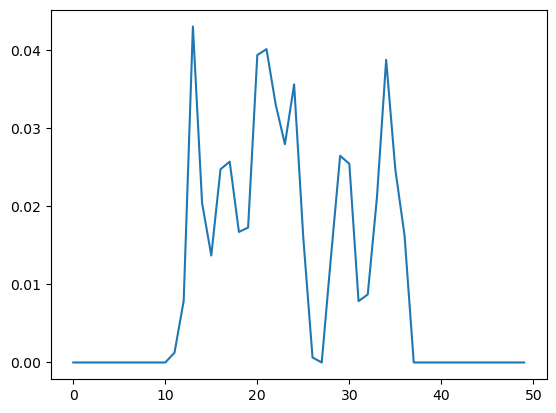

In [46]:
densityField, densityFieldSpacing, densityFieldCorner = courseGrainField(data, returnSpacing=True, returnCorner=True)

densityField = densityField.astype(np.float64)
i = 3

lineDirection = linePoints[i,1] - linePoints[i,0]

path = np.multiply.outer(np.linspace(-.5, 1.5, 50), lineDirection) + linePoints[i,0]
#path = np.multiply.outer(np.linspace(-.5, 1.5, 50), lineDirection) + np.random.uniform(-1/2, 1/2, size=3)

plt.plot(pathIntegralAlongField3D(densityField, path, densityFieldSpacing, densityFieldCorner))
plt.show()

In [47]:
def findLineIntersection(aArr, bArr):
    """
    Find the line intersection of a collection of
    lines defined in the format:
    $$ \vec p = \vec a + \vec b t$$

    If the lines do not all intersect (in d >= 3), the point at which
    the lines all pass closest to will be returned.

    Parameters
    ----------
    aArr : numpy.ndarray[N,d]
        The anchor points for each line.

    bArr : numpy.ndarray[N,d]
        The direction (unit) vectors for each line.

    Returns
    -------
    closestPoint : numpy.ndarray[d]
        Intersection point or closest mutual point.
    """
    # Modified from:
    # https://stackoverflow.com/questions/48154210/3d-point-closest-to-multiple-lines-in-3d-space
    
    # Grab the number of line and the dimension we are in.
    nLines, d = aArr.shape

    # Compute dot product
    da = np.sum(bArr * aArr, axis=-1, keepdims=True)
    
    b = np.sum(bArr * da - aArr, axis=0)
    m = np.inner(bArr.T, bArr.T) - np.diag(np.full(d, nLines))
    return np.linalg.solve(m, b)

def connectLines(lines, distanceThreshold=0.01, smoothingDistance=0.1):
    """
    """
    newLines = []
    connectedLines = np.copy(lines)

    for i in range(len(lines)):
        for j in range(len(lines)):
            if i == j:
                continue

            # Switch to a + bt form
            a1 = lines[i][0]
            a2 = lines[j][0]
            b1 = lines[i][1] - lines[i][0]
            b2 = lines[j][1] - lines[j][0]
            b1 /= np.sqrt(np.sum(b1**2))
            b2 /= np.sqrt(np.sum(b2**2))
            
            aArr = np.array([a1, a2])
            bArr = np.array([b1, b2])
            # Compute the point of closest pass of the two lines
            nearestPoint = findNearestPoint(aArr, bArr)
            # Now find the points on each line closest to that point
            paramArr = [np.dot(bArr[k], nearestPoint - aArr[k]) for k in range(2)]
            nearestPointOnLines = np.array([aArr[k] + paramArr[k] * bArr[k] for k in range(2)])

            # Compute the distances so we can see if we should connect these two lines
            distances = np.sqrt(np.sum((nearestPoint - nearestPointOnLines)**2))

            if np.max(distances) <= distanceThreshold:
                # If the lines are close enough to intersecting, we
                # add some extra lines that connect things

                # Most basic attempt: add the closest pass point
                # as a midpoint for both lines
                newLines.append([lines[i][0], nearestPoint])
                newLines.append([nearestPoint, lines[i][1]])
                newLines.append([lines[j][0], nearestPoint])
                newLines.append([nearestPoint, lines[j][1]])

                lineIndicesToRemove.append(i)
                lineIndicesToRemove.append(j)

            # import open3d as o3d
            
            # flattenedLinePoints = lines[[i,j]].reshape((len(lines[[i,j]])*2, 3))
            
            # lineSet = o3d.geometry.LineSet()
            # lineSet.points = o3d.utility.Vector3dVector(flattenedLinePoints)
            # lineSet.lines = o3d.utility.Vector2iVector([[i,i+1] for i in range(len(flattenedLinePoints))[::2]])
            
            # pcd = o3d.geometry.PointCloud()
            # pcd.points = o3d.utility.Vector3dVector(np.array([nearestPoint, *nearestPointOnLines]))
            
            # o3d.visualization.draw_geometries([lineSet, pcd])

            # Compute closest pass distance (or intersection point
            # if they do intersect)

    lineIndicesToRemove = np.unique(lineIndicesToRemove)
    keepIndices = np.array([i for i in range(len(lines)) if i not in lineIndicesToRemove], dtype=np.int64)
    trimmedLines = lines[keepIndices]
    connectedLines = np.concatenate((trimmedLines, np.array(newLines)))

    return connectedLines

In [50]:
connectedLines = connectLines(linePoints, distanceThreshold=0.5)

flattenedLinePoints = connectedLines.reshape((len(connectedLines)*2, 3))

lineSet = o3d.geometry.LineSet()
lineSet.points = o3d.utility.Vector3dVector(flattenedLinePoints)
lineSet.lines = o3d.utility.Vector2iVector([[i,i+1] for i in range(len(flattenedLinePoints))[::2]])

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(data)

o3d.visualization.draw_geometries([lineSet])